## Bienvenidos al Notebook del trade de los márgenes cruzados

En este notebook vamos a calcular el funding rate para el perpetuo de Bitcoin entre Binance y Bybit. Para ello hemos de descargar los datos históricos de los funding rat para ambos exchanges. Nosotros hemos descargado los datos y los hemos puesto en el repositorio para que no tengáis que descargarlos. Os dejamos los enlaces para que podáis descargar otros intervalos temporales u otras criptomendas: [datos históricos de funding para Binance](https://www.binance.com/en/futures/funding-history/perpetual/funding-fee-history) y [datos históricos de funding para Bybit](https://www.bybit.com/data/basic/linear/funding-history?symbol=BTCUSDT).

<span style="color:blue">Importante: instalar las librerías para que el código funcione.</span> Simplemente ejecutad el siguiente comando desde una terminal en la misma ruta del código: python -m pip install -r requirements.txt.

In [1]:
# Importamos las liberías para trabajar con datos y gráficos
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

# https://stackoverflow.com/questions/47404653/pandas-0-21-0-timestamp-compatibility-issue-with-matplotlib 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Lo primero de todo es leer ambas series de datos como un DataFrame de pandas

In [2]:
funding_binance = pd.read_csv('funding_rate_btc_binance.csv')
funding_binance.head(5)

,Time,Contracts,Funding Interval,Funding Rate
0,2023-08-18 10:00:00,BTCUSDT Perpetual,8h,-0.000046%
1,2023-08-18 02:00:00,BTCUSDT Perpetual,8h,0.010000%
2,2023-08-17 18:00:00,BTCUSDT Perpetual,8h,0.010000%
3,2023-08-17 10:00:00,BTCUSDT Perpetual,8h,0.010000%
4,2023-08-17 02:00:00,BTCUSDT Perpetual,8h,0.010000%


In [3]:
funding_bybit = pd.read_excel('funding_rate_btc_bybit.xlsx')
funding_bybit.head(5)

,Time(UTC),Symbol,Funding Rate
0,2023-08-18 08:00:00,BTCUSDT,-0.000005
1,2023-08-18 00:00:00,BTCUSDT,0.000064
2,2023-08-17 16:00:00,BTCUSDT,0.000100
3,2023-08-17 08:00:00,BTCUSDT,0.000100
4,2023-08-17 00:00:00,BTCUSDT,0.000100


A continuación vamos a:
- Seleccionar la columna de Funding Rate
- Establecer la columna de tiempo como índice del dataframe y convertir a formato datetime
- Descartar el resto de las columnas

Además, podréis observar que la hora de Bybit es UTC mientras que la de Binance es UTC+2. Para sincronizarlas restaremos dos horas a Binance, quedadno así ambos exchanges en UTC.

Por último, habremos de transformar el funding rate de tipo cadena a tipo flotante.

In [4]:
format_ = '%Y-%m-%d %H:%M:%S'
funding_binance['ts'] = funding_binance['Time'].apply(lambda x: datetime.strptime(x, format_) - timedelta(hours=2))
funding_bybit['ts'] = funding_bybit['Time(UTC)'].apply(lambda x: datetime.strptime(x, format_))

funding_binance['FundingBinance'] = funding_binance['Funding Rate'].apply(lambda x: float(x[:-1]))
funding_bybit['FundingBybit'] = funding_bybit['Funding Rate']

funding_binance.set_index('ts', inplace=True)
funding_bybit.set_index('ts', inplace=True)

funding_binance = funding_binance['FundingBinance']
funding_bybit = funding_bybit['FundingBybit']

In [5]:
funding_binance.head(5)

ts
2023-08-18 08:00:00   -0.000046
2023-08-18 00:00:00    0.010000
2023-08-17 16:00:00    0.010000
2023-08-17 08:00:00    0.010000
2023-08-17 00:00:00    0.010000
Name: FundingBinance, dtype: float64

In [6]:
funding_bybit.head(5)

ts
2023-08-18 08:00:00   -0.000005
2023-08-18 00:00:00    0.000064
2023-08-17 16:00:00    0.000100
2023-08-17 08:00:00    0.000100
2023-08-17 00:00:00    0.000100
Name: FundingBybit, dtype: float64

Juntemos ambos dataframe haciéndolos coincidir por timestamp y eliminemos las celdas vacías.

In [7]:
total_df = pd.concat([funding_binance, funding_bybit], axis=1)
total_df.dropna(inplace=True)
total_df.head(5)

,FundingBinance,FundingBybit
ts,,
2020-03-29 08:00:00,-0.029120,0.0001
2020-03-29 16:00:00,-0.025613,0.0001
2020-03-30 00:00:00,-0.064310,0.0001
2020-03-30 08:00:00,-0.033817,0.0001
2020-03-30 16:00:00,-0.006982,0.0001


Vamos a calcular el rendimiento desde marzo de 2020 si entramos largo de Binance y corto de Bybit. 

Es importante tener dos cosas en cuenta:
- Las ganancias o pérdidas no se acumulan.
- Si el funding rate es positivo entonces el que va largo del contrato ha de pagar, y el que va corto lo recibe.

Vamos a asumir una inversión de 1000€ en total. Esta inversión se repartiriía: 500€ para comprar y 500 para vender.

In [17]:
inversion = 1000 # Euros

total_df['PnLCompra'] = (-1) * total_df.FundingBinance / 100 * inversion / 2
total_df['PnLVenta'] = total_df.FundingBybit / 100 * inversion / 2
total_df['PnLDiario'] = total_df.PnLCompra + total_df.PnLVenta

total_df.head(5)

,FundingBinance,FundingBybit,PnLDiario,PnLCompra,PnLVenta
ts,,,,,
2020-03-29 08:00:00,-0.029120,0.0001,0.146100,0.145600,0.0005
2020-03-29 16:00:00,-0.025613,0.0001,0.128565,0.128065,0.0005
2020-03-30 00:00:00,-0.064310,0.0001,0.322050,0.321550,0.0005
2020-03-30 08:00:00,-0.033817,0.0001,0.169585,0.169085,0.0005
2020-03-30 16:00:00,-0.006982,0.0001,0.035410,0.034910,0.0005


A cocntinuación calculamos el PnL acumulado

In [19]:
total_df['PnLAcumulado'] = total_df.PnLDiario.cumsum()
total_df.head(5)

,FundingBinance,FundingBybit,PnLDiario,PnLCompra,PnLVenta,PnLAcumulado
ts,,,,,,
2020-03-29 08:00:00,-0.029120,0.0001,0.146100,0.145600,0.0005,0.146100
2020-03-29 16:00:00,-0.025613,0.0001,0.128565,0.128065,0.0005,0.274665
2020-03-30 00:00:00,-0.064310,0.0001,0.322050,0.321550,0.0005,0.596715
2020-03-30 08:00:00,-0.033817,0.0001,0.169585,0.169085,0.0005,0.766300
2020-03-30 16:00:00,-0.006982,0.0001,0.035410,0.034910,0.0005,0.801710


Veamos la evolución del PnL acumulado en un gráfico

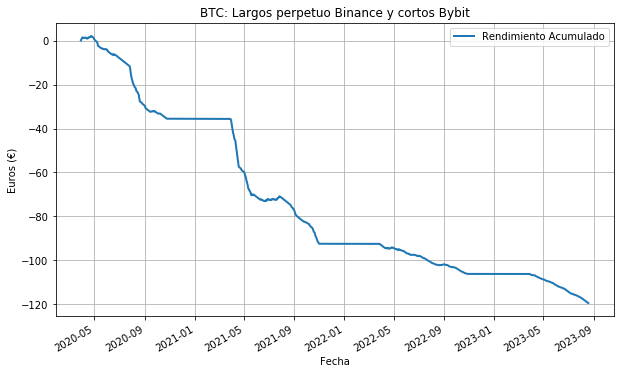

In [21]:
plt.figure(figsize=(10, 6))
fechas = total_df.index
plt.plot(fechas, total_df.PnLAcumulado.values, label='Rendimiento Acumulado', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Euros (€)')
plt.title('BTC: Largos perpetuo Binance y cortos Bybit')
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()
# plt.savefig('btc_perp.png', format='png', dpi = 500)
plt.show()

¡Vaya! Esta trade supone una pérdida de 120€ en 1237 días (3.4 años). 

¿A alguno de vosotros se le ocurre cómo arreglarlo? ¡Exacto! Le damos la vuelta al trade, de forma que vayamos largos en Bybit cortos en Binance, así obtendríamos 120€ de beneficio en 1237 días.

In [24]:
(total_df.index[-1] - total_df.index[0]).days

1237

In [23]:
(total_df.index[-1] - total_df.index[0]).days / 365

3.389041095890411

Calculemos el rendimiento anualizado

In [25]:
120 / inversion * 100

12.0

Los 120€ suponen un 12% de la inversión pero en 1237 días.

In [27]:
12 / 1237 * 365

3.540824575586096

Aquí lo tenemos, un 3.5% anual sobre la inversión

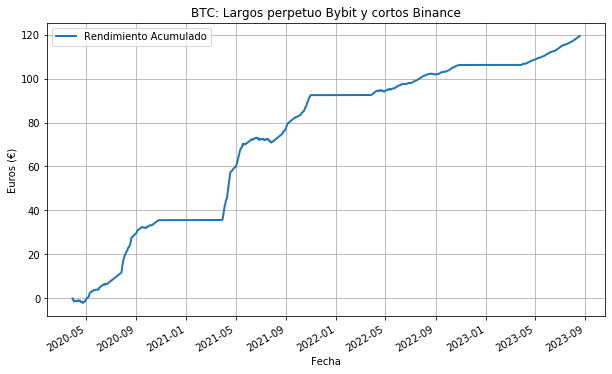

In [29]:
plt.figure(figsize=(10, 6))
fechas = total_df.index
plt.plot(fechas, -total_df.PnLAcumulado.values, label='Rendimiento Acumulado', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Euros (€)')
plt.title('BTC: Largos perpetuo Bybit y cortos Binance')
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig('btc_perp.png', format='png', dpi = 500)
plt.show()